# rRNA Paralog - General Workflow
```
pi:ababaian
files: ~/Crown/data/..
start: 2017 04 10
complete : 2017 04 12
```
## Introduction

One of the central conjectures of rRNA variant paper is that the abundant / prevelant variants in the 107 genomes are paralogs of RNA45S, with distinct intra-cellular functions.

If that is assumed to be true then it follows that under conditions of global translational differences that the paralogs would be differentially expressed as the 'class' of translation shifts.

* Senescence
* Transformation
* [Myc Activation/Proliferation](./20170410_rRNA_Paralog_Myc.ipynb)
* Interferon Treatment: [IFNg](./20170410_rRNA_Paralog_IFNg.ipynb)
* ...


## Workflow

### Identify Data-set

 1) On [GEO](https://www.ncbi.nlm.nih.gov/geo/) find the dataset of [interest](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70009).
 * Illumina RNA-seq
 * Single or paired-end
 * Poly-A Selected (rRNA-depleted is untested)
 
 The most important consideration is to make sure the 'controls' are matched in a meaningful way. Unless there are very high numbers of individuals, differences between people confound the analysis. So looking at 'intra-ndividual' differences are key in the control.
  
 2) On the [SRA](https://www.ncbi.nlm.nih.gov/Traces/study/?WebEnv=NCID_1_105940910_130.14.22.33_5555_1491871653_1651226577_0MetA0_S_HStore&query_key=19) select the runs of interest and download the 'SRA_data' to a spreadsheet or text file. (~/Crown/data/myc/Myc_data.xlsx)
 
### Download and parse the data 

 3) Sub-select SRA Run identifiers for the libraries to include in the study and pre-fetch/dump the data
 
 ```
 #!/bin/bash

# Prefetch data from SRA
prefetch SRR2939550
prefetch SRR2939551
prefetch SRR2939552
prefetch SRR2939554
prefetch SRR2939555

# Dump to FQ files
fastq-dump --gzip  SRR2939550
fastq-dump --gzip  SRR2939551
fastq-dump --gzip  SRR2939552
fastq-dump --gzip  SRR2939554
fastq-dump --gzip  SRR2939555
```

 4) Annotate the run ID for the 'siMyc_data.txt' file
 
 ```
siCtrl_1	IMEC	SRS1171731	inVitro	SRR2939550.fastq.gz
siCtrl_1B	IMEC	SRS1171730	inVitro	SRR2939551.fastq.gz
siMYC_1	IMEC	SRS1171729	inVitro	SRR2939552.fastq.gz
siCtrl_2	IMEC	SRS1171727	inVitro	SRR2939554.fastq.gz
siMYC_2	IMEC	SRS1171726	inVitro	SRR2939555.fastq.gz
```

### Align to hgr1 and sub-set

5) With the `siMyc_data.txt` as input, run the alignment to hgr1


In [ ]:
#!/bin/bash
# siMyc_align_hgr1.fa
# rDNA alignment pipeline
# for Myc data on local machine

# Control Panel -------------------------------

# Project Dir
  BASE='~/Crown/data/myc/siMyc/'
  cd $BASE

# Sequencing Data
  CRC_DIR='~/Crown/data/myc/siMyc/'
  LIB_LIST='siMyc_data.txt' # list of fastq files in hgr1 format
  
# CPU
  THREADS='1'
  
# Initialize start-up sequence ----------------
# Make working directory
  mkdir -p align

#Resources
  cp ~/Crown/resources/hgr1/hgr1.fa ./
  samtools faidx hgr1.fa
  bowtie2-build hgr1.fa hgr1


# ---------------------------------------------
# SCRIPT LOOP ---------------------------------
# ---------------------------------------------
# For each line in input LIB_LIST; run the pipeline

cat $LIB_LIST | while read LINE
do
    #Initialize Run
    echo "Start Iteration:"
    echo "  $LINE"
    echo ''
    
    LIBRARY=$(echo $LINE | cut -f1 -d' ' -) # Library Name
    RGSM=$(echo $LINE | cut -f2 -d' ' -)    # Sample / Patient Identifer
    RGID=$(echo $LINE | cut -f3 -d' ' -)    # Read Group ID
    RGLB=$(echo $LINE | cut -f3 -d' ' -)    # Library Name. Accession Number
    RGPL='ILLUMINA'                   # Sequencing Platform.
    RGPO=$(echo $LINE | cut -f4 -d' ' -)    # Patient Population

    FASTQ1=$(echo $LINE | cut -f5 -d' ' -)  # Filename Read 1   
    FQ1="$CRC_DIR/$FASTQ1"            # Fastq1 Filepath

    echo "Lib: $LIBRARY"
    echo "RGSM: $RGSM"
    echo "RGID: $RGID"
    echo "RGLB: $RGLB"
    echo "RGPL: $RGPL"
    echo "RGPO: $RGPO"
    echo "FQ: $FQ1"
    echo ''
    echo ''
    
    # Extract Sequencing Run Info
    RGPU=$(gzip -dc $FQ1 | head -n1 - | cut -f1 -d'.' | cut -f2 -d'@')
    
    # Bowtie2: align to genome
    bowtie2 --very-sensitive-local -p $THREADS --rg-id $RGID \
      --rg LB:$RGLB --rg SM:$RGSM \
      --rg PL:$RGPL --rg PU:$RGPU \
      -x hgr1 -U $FQ1 |\
      samtools view -bS - > aligned_unsorted.bam
      
    # Calcualte library flagstats
    samtools flagstat aligned_unsorted.bam > aligned_unsorted.flagstat


    # Rename the total Bam Files
      mv aligned_unsorted.bam $LIBRARY.bam
      mv aligned_unsorted.bam.bai $LIBRARY.bam.bai
      mv aligned_unsorted.flagstat $LIBRARY.flagstat


done

# Primary VCF ----------------------------
# N/A

# Script complete

  6) Sub-set the data to remove unmapped reads (reduces disk footprint but not neccesary)

In [ ]:
#!/bin/bash
#
# readSubset.sh
#

for LIBRARY in $(ls *.bam | cut -f1 -d'.' -)
do

  # Read Subset ------------------------------
    # Extract mapped reads, and their unmapped pairs

      # Extract Header
      samtools view -H $LIBRARY.bam > align.header.tmp

      # Extract Mapped Reads (single-end)
      samtools view -b -F 4 $LIBRARY.bam > align.F4.bam #mapped

        samtools sort align.F4.bam -o align.hgr1.bam
        samtools index align.hgr1.bam
        samtools flagstat align.hgr1.bam > align.hgr1.flagstat

      # Clean up 
      rm *tmp* align.F4.bam align.f4F8.bam

    # Rename/move the hgr1 Bam files
      mv align.hgr1.bam ../bam/$LIBRARY.hgr1.bam
      mv align.hgr1.bam.bai ../bam/$LIBRARY.hgr1.bam.bai
      mv align.hgr1.flagstat ../bam/$LIBRARY.hgr1.flagstat

done

### Calculate Reference/Alternative Allelic Depth per position

7) `adCalc.sh`: Calculates a GVCF file for a set of bam files defined in 'bam.list'


In [6]:
cd ~/Crown/data/myc/

cd siMyc/bam

ls *.bam > bam.list

cp ~/Crown/resources/hgr1/hgr1.fa ./
samtools faidx hgr1.fa

In [7]:
#!/bin/bash
# ADcalc.sh
# Allelic Depth Calculator
# for a range of coordinates

# Controls -----------------
REGION1='chr13:1003661-1005529'
REGION2='chr13:1007948-1013560'
# chr13:1003661-1005529 18S
# chr13:1007948-1013560 28S

OUTPUT1='18S_siMyc.gvcf'
OUTPUT2='28S_siMyc.gvcf'

DEPTH='100000'
BAMLIST='bam.list'

# Iterate through every bam file in directory
# look-up position and return VCF

## Region 1: 18S
    bcftools mpileup -f hgr1.fa \
  --max-depth $DEPTH --min-BQ 30 \
  -a FORMAT/DP,AD \
  -r $REGION1 \
  --ignore-RG \
  -b $BAMLIST |
  bcftools annotate -x INFO,FORMAT/PL - |
  bcftools view -O v -H - >> $OUTPUT1

## Region 2: 28S
    bcftools mpileup -f hgr1.fa \
  --max-depth $DEPTH --min-BQ 30 \
  -a FORMAT/DP,AD \
  -r $REGION2 \
  --ignore-RG \
  -b $BAMLIST |
  bcftools annotate -x INFO,FORMAT/PL - |
  bcftools view -O v -H - >> $OUTPUT2


[mpileup] 5 samples in 5 input files
[mpileup] 5 samples in 5 input files


### Analysis of Allelic Depth between groups

8) Parse and analyze the .gvcf file from adCalc.sh in R

(Switch kernel and change folder)

In [11]:
# Switch Kernel in Jupyter manually
setwd("/home/artem/Crown/data/myc/analysis/")


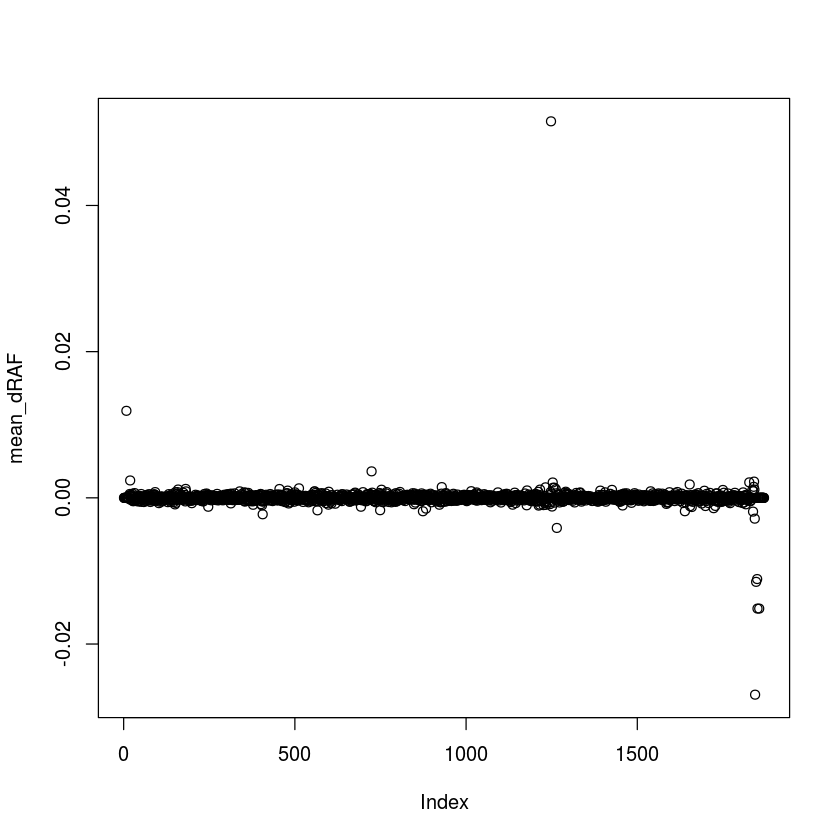

In [13]:
# rrnaAnalysis.R
#
# Analysis of adCalc.sh
# output gvcf files
#
library(ggplot2)

# Import
GVCF = read.table('18S_siMyc.gvcf')
  GVCF = data.frame(t(GVCF))
  colnames(GVCF) = seq(1, length(GVCF[1,]))

# Cut 28S to just 28S (5071 bases)
# chr13    1007948    1013018    28S
  # trim = which( (apply(GVCF[2,], 1, as.numeric) < 1007949) |
  #                 (apply(GVCF[2,], 1 , as.numeric) > 1013018) )
  # GVCF = GVCF[, -trim]

  
# Cut 18S to just 18S (1869 bases)
# chr13    1003661    1005529    18S
  # trim = which( (apply(GVCF[2,], 1, as.numeric) < 1003661) |
  #               (apply(GVCF[2,], 1 , as.numeric) > 1005529) )
  # GVCF = GVCF[, -trim]

# Cut 5.8S to just 5.8S (1869 bases)
# chr13    1006622    1006779    18S
  # trim = which( (apply(GVCF[2,], 1, as.numeric) < 1006623) |
  #                 (apply(GVCF[2,], 1 , as.numeric) > 1006779) )
  # GVCF = GVCF[, -trim]
  

refAllele = GVCF[4,]
altAllele = GVCF[5,]
genCoord  = GVCF[2,]
rnaCoord  = seq(1, length(GVCF[2,]))

sampleN = length(GVCF[,1]) - 9 # remove 9 header vcf rows
bpN     = length(genCoord) # 1869 for 18S; 5071 for 28S

# Functions =========================================================

# Convert DP:AD string to numeric DP (Total Depth)
dpCalc = function(inSTR){
# inSTR is from vcf
# in format DP:AD
# 2000:1500,400,50,50
# extract 2000
inSTR = as.character(inSTR)
as.numeric(unlist(strsplit(inSTR,split=':'))[1])

}

# Convert DP:AD string to numeric RD for the REFERENCE ALLELE DEPTH
# Thus Alternative_Allele_Depth = Total_Depth - Reference_Allele_Depth
# for all alternative alleles.
rdCalc = function(inSTR){
  # inSTR is from vcf
  # in format DP:AD
  # 2000:1500,400,50,50
  # extract 1500
  inSTR = as.character(inSTR)
  as.numeric(unlist(strsplit(unlist(strsplit(inSTR,split=":"))[2], split = ","))[1])
  
}


# Calculations ======================================================
# Calculate Depth of Coverage (baq > 30)
# for all positions

#Initialize DP vector
DP = vapply( GVCF[-c(1:9),1], dpCalc, 1)

#Extend the DP vector for all positions
for (i in 2:bpN){
DP = cbind(DP,
           vapply( GVCF[-c(1:9),i], dpCalc, 1) )
}

# Calculate Reference Depth of Coverage (baq > 30)
# for all positions
#
#Initialize
RD = vapply( GVCF[-c(1:9),1], rdCalc, 1)

#The rest
for (i in 2:bpN){
  RD = cbind(RD,
             vapply( GVCF[-c(1:9),i], rdCalc, 1) )
}


# Reference Allele Frequency
# Intra-Library
# RD / DP
RAF = RD / DP

# NOTE: division by zero is possible here and will introduce NAs


# Deconvolute Sample A from Sample B
# siCTRL = Row 1 - 3
# siMyc  = Row 4 - 5
RAF_A = RAF[1:3,]
RAF_B = RAF[4:5,]
              
# Change in Reference Allele Frequency
 # (For Paired-Samples) ----------------------

# dRAF = RAF_A - RAF_B
# 
# # Calculate some descriptive statistics
# # about the change in Reference Allele Frequency
# # Remove NA from calculations (no sequencing depth in a library)
# mean_dRAF = apply(dRAF,2,mean, na.rm = TRUE)
# sd_dRAF   = apply(dRAF,2,sd, na.rm = TRUE)
# var_dRAF  = apply(dRAF,2,var, na.rm = TRUE)
# mean_DP = apply(DP,2,mean, na.rm = TRUE)


 # (For unpaired samples) --------------------
 mean_dRAF = apply(RAF_A, 2, mean, na.rm = TRUE) - 
  apply(RAF_B, 2, mean, na.rm = TRUE)


# Remove poorly 'covered' positions (i.e. less then 1000x coverage on average)
# the magnitude of bias is simply too high at such regions
#dropPOS = (mean_DP < 100)
#RAF_A[,dropPOS]  = 0
#RAF_B[,dropPOS] = 0

plot(mean_dRAF)

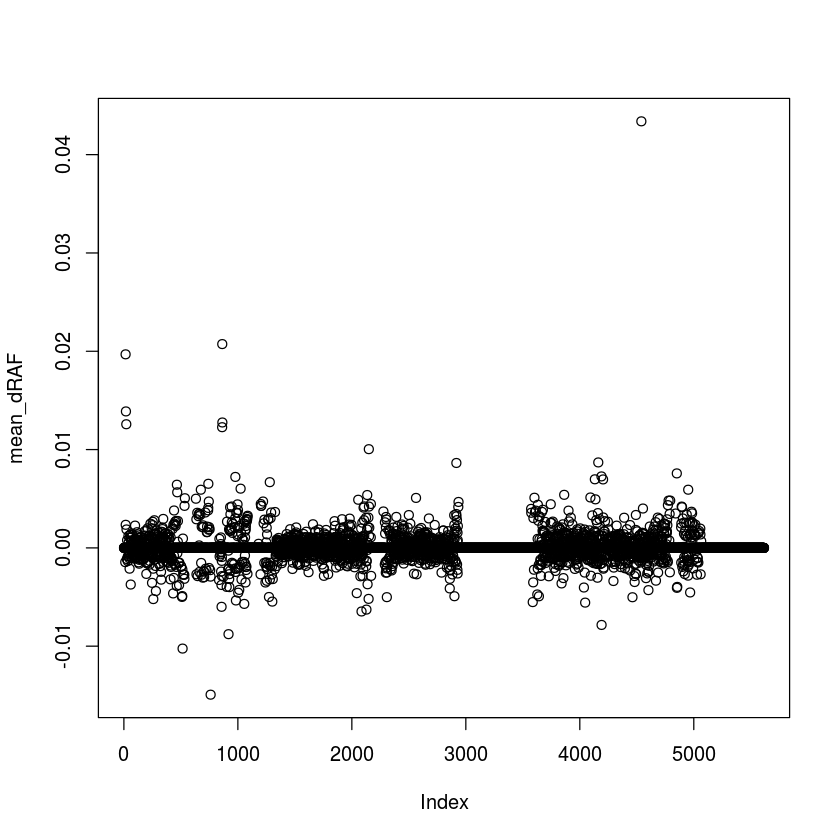

In [16]:
# rrnaAnalysis.R
#
# Analysis of adCalc.sh
# output gvcf files
#
library(ggplot2)

# Import
GVCF = read.table('28S_siMyc.gvcf')
  GVCF = data.frame(t(GVCF))
  colnames(GVCF) = seq(1, length(GVCF[1,]))

# Cut 28S to just 28S (5071 bases)
# chr13    1007948    1013018    28S
  # trim = which( (apply(GVCF[2,], 1, as.numeric) < 1007949) |
  #                 (apply(GVCF[2,], 1 , as.numeric) > 1013018) )
  # GVCF = GVCF[, -trim]

  
# Cut 18S to just 18S (1869 bases)
# chr13    1003661    1005529    18S
  # trim = which( (apply(GVCF[2,], 1, as.numeric) < 1003661) |
  #               (apply(GVCF[2,], 1 , as.numeric) > 1005529) )
  # GVCF = GVCF[, -trim]

# Cut 5.8S to just 5.8S (1869 bases)
# chr13    1006622    1006779    18S
  # trim = which( (apply(GVCF[2,], 1, as.numeric) < 1006623) |
  #                 (apply(GVCF[2,], 1 , as.numeric) > 1006779) )
  # GVCF = GVCF[, -trim]
  

refAllele = GVCF[4,]
altAllele = GVCF[5,]
genCoord  = GVCF[2,]
rnaCoord  = seq(1, length(GVCF[2,]))

sampleN = length(GVCF[,1]) - 9 # remove 9 header vcf rows
bpN     = length(genCoord) # 1869 for 18S; 5071 for 28S

# Functions =========================================================

# Convert DP:AD string to numeric DP (Total Depth)
dpCalc = function(inSTR){
# inSTR is from vcf
# in format DP:AD
# 2000:1500,400,50,50
# extract 2000
inSTR = as.character(inSTR)
as.numeric(unlist(strsplit(inSTR,split=':'))[1])

}

# Convert DP:AD string to numeric RD for the REFERENCE ALLELE DEPTH
# Thus Alternative_Allele_Depth = Total_Depth - Reference_Allele_Depth
# for all alternative alleles.
rdCalc = function(inSTR){
  # inSTR is from vcf
  # in format DP:AD
  # 2000:1500,400,50,50
  # extract 1500
  inSTR = as.character(inSTR)
  as.numeric(unlist(strsplit(unlist(strsplit(inSTR,split=":"))[2], split = ","))[1])
  
}


# Calculations ======================================================
# Calculate Depth of Coverage (baq > 30)
# for all positions

#Initialize DP vector
DP = vapply( GVCF[-c(1:9),1], dpCalc, 1)

#Extend the DP vector for all positions
for (i in 2:bpN){
DP = cbind(DP,
           vapply( GVCF[-c(1:9),i], dpCalc, 1) )
}

# Calculate Reference Depth of Coverage (baq > 30)
# for all positions
#
#Initialize
RD = vapply( GVCF[-c(1:9),1], rdCalc, 1)

#The rest
for (i in 2:bpN){
  RD = cbind(RD,
             vapply( GVCF[-c(1:9),i], rdCalc, 1) )
}


# Reference Allele Frequency
# Intra-Library
# RD / DP
RAF = RD / DP

# NOTE: division by zero is possible here and will introduce NAs


# Deconvolute Sample A from Sample B
# siCTRL = Row 1 - 3
# siMyc  = Row 4 - 5
RAF_A = RAF[1:3,]
RAF_B = RAF[4:5,]
              
# Change in Reference Allele Frequency
 # (For Paired-Samples) ----------------------

# dRAF = RAF_A - RAF_B
# 
# # Calculate some descriptive statistics
# # about the change in Reference Allele Frequency
# # Remove NA from calculations (no sequencing depth in a library)
# mean_dRAF = apply(dRAF,2,mean, na.rm = TRUE)
# sd_dRAF   = apply(dRAF,2,sd, na.rm = TRUE)
# var_dRAF  = apply(dRAF,2,var, na.rm = TRUE)
# mean_DP = apply(DP,2,mean, na.rm = TRUE)

# Remove poorly 'covered' positions (i.e. less then 1000x coverage on average)
# the magnitude of bias is simply too high at such regions
mean_DP = apply(DP,2, mean, na.rm = TRUE)
dropPOS = (mean_DP < 100)

RAF_A[,dropPOS]  = 0
RAF_B[,dropPOS] = 0

 # (For unpaired samples) --------------------
 mean_dRAF = apply(RAF_A, 2, mean, na.rm = TRUE) - 
  apply(RAF_B, 2, mean, na.rm = TRUE)


plot(mean_dRAF)


In [19]:
hits = which(mean_dRAF > 0.04)

GVCF[,hits]

RAF[,hits]

V1               V2               V3               V4 
           chr13          1012480                .                T 
              V5               V6               V7               V8 
           G,A,C                0                .                . 
              V9              V10              V11              V12 
           DP:AD  283:185,53,43,2  241:146,49,46,0 468:269,112,85,2 
             V13              V14 
 298:173,69,55,1  261:145,61,55,0 
12 Levels: . 0 1012480 241:146,49,46,0 261:145,61,55,0 ... T

[1] 0.6537102 0.6058091 0.5747863 0.5805369 0.5555556


	Welch Two Sample t-test

data:  RAF_A[, pos] and RAF_B[, pos]
t = 1.6602, df = 2.8584, p-value = 0.1999
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.04216222  0.12894022
sample estimates:
mean of x mean of y 
0.6114352 0.5680462 



	F test to compare two variances

data:  RAF_A[, pos] and RAF_B[, pos]
F = 5.0667, num df = 2, denom df = 1, p-value = 0.5994
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 6.337348e-03 1.951004e+02
sample estimates:
ratio of variances 
           5.06671 


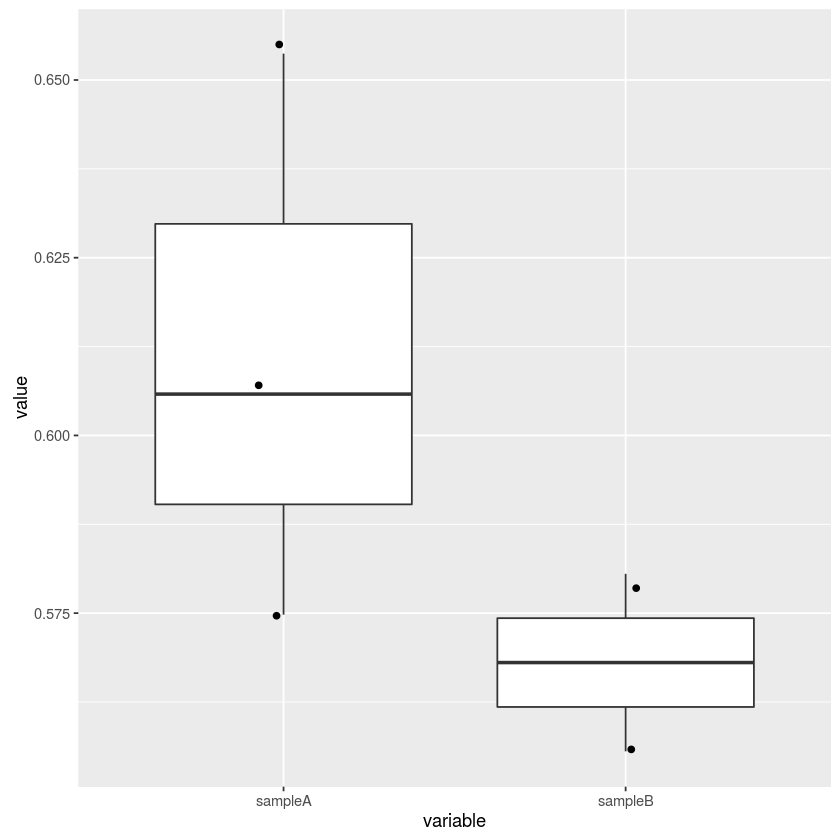

In [20]:
# basePlot.r
#
# Analysis and plot the data
# for a single base (after running crcAnalysis.r)
#

library(ggplot2)
library(reshape2)

# Position of interest
# in hgr1 / chr13 coordinates 
# 28S.59G / hgr1:1008007
# 28S.470A / hgr1:1008418
# 28S.4532U / hgr1:1012480
# 18S.1248U / hgr1:1004908

pos ='1012480'
  pos = which(genCoord == pos)

# paired analysis ----------------------------------
    
# Change in allele frequency between sampleA-sampleB
#POS = data.frame(dRAF[,pos]) # paired
# # Raw reference allele frequency
# POS$sampleA_RAF = RAF_A[,pos]
# POS$sampleB_RAF = RAF_B[,pos]
# 
# # Depth of coverage at position of interest
# POS$sampleA_DP = DP[idxA, pos]
# POS$sampleB_DP = DP[idxB, pos]
# 
# # Plot RAF_A vs. RAF_B
# POSDATA = melt(POS[,2:3])
  
# unpaired analysis -------------------------------
# Raw reference allele frequency
POSDATA = data.frame( c(RAF_A[,pos], RAF_B[,pos] ))
  colnames(POSDATA) = 'value'
  
POSDATA$variable = c( rep('sampleA', length(RAF_A[,pos]) ),
                      rep('sampleB', length(RAF_B[,pos]) ))

# # Depth of coverage at position of interest
# POS$sampleA_DP = DP[idxA, pos]
# 
# POS$sampleB_DP = DP[idxB, pos]

PLOT = ggplot(POSDATA, aes(variable, value)) +
  geom_boxplot(stat = 'boxplot') + 
  geom_jitter( width = 0.2)
PLOT

# Test for signifiance
t.test(RAF_A[,pos], RAF_B[,pos], paired = FALSE)
var.test(RAF_A[,pos], RAF_B[,pos])


# Plot change in reference allele frequency
# comapred to a sampleB distribution with the same
# standard deviation (null hypothesis)

# POS$sim_dRAF = rnorm(sampleN/2, mean = 0,
#                      sd = sd(POS$dRAF))
# 
# POSDATA = melt(POS[,c(1,6)])

# Plot dRAF alone
# PLOT = ggplot(POS, aes('delta 28S.r.59G', dRAF)) +
#   geom_boxplot(stat = 'boxplot') +
#   geom_jitter(width = 0.2)
# PLOT

# Plot dRAF vs. Normal Distribution
# PLOT = ggplot(POSDATA, aes(variable, value)) +
#   geom_boxplot(stat = 'boxplot') + 
#   geom_jitter( width = 0.2)
# PLOT
# 
# t.test(POS$dRAF, POS$sim_dRAF, paired = FALSE)
# var.test(POS$dRAF, POS$sim_dRAF)
